In [1]:
import scanpy as sc
import numpy as np
from ndreamer import NDreamer

# The estimated ITE for the real data

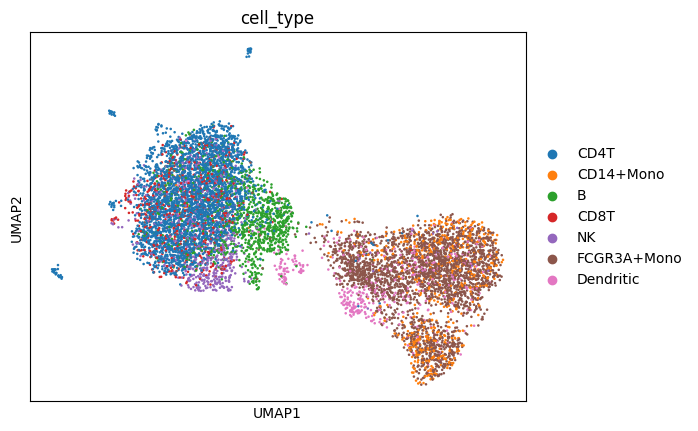

In [2]:
ITE=sc.read_h5ad("./PBMC/b-0--c-1__ITE.h5ad")

sc.pp.pca(ITE)
sc.pp.neighbors(ITE)
sc.tl.umap(ITE)
sc.pl.umap(ITE, color=['cell_type'], ncols=1)

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/compat/__init__.py:358: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/compat/__init__.py:358: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'
condition ['control' 'stimulated']
cell_type ['B' 'CD14+Mono' 'CD4T' 'CD8T' 'Dendritic' 'FCGR3A+Mono' 'NK']
  (0, 6)	3.206646203994751
  (0, 7)	0.9476891756057739
  (1, 6)	3.3140597343444824
  (2, 6)	2.344876527786255
  (3, 6)	2.292093276977539
  (4, 6)	2.430964708328247
  (5, 3)	0.29651933908462524
  (5, 6)	3.045463800430298
  (6, 6)	2.0396549701690674
  (7, 6)	3.98563814163208
  (8, 5)	0.5871325731277466
  (8, 6)	4.5311431884765625
  (9, 6)	2.4054837226867676


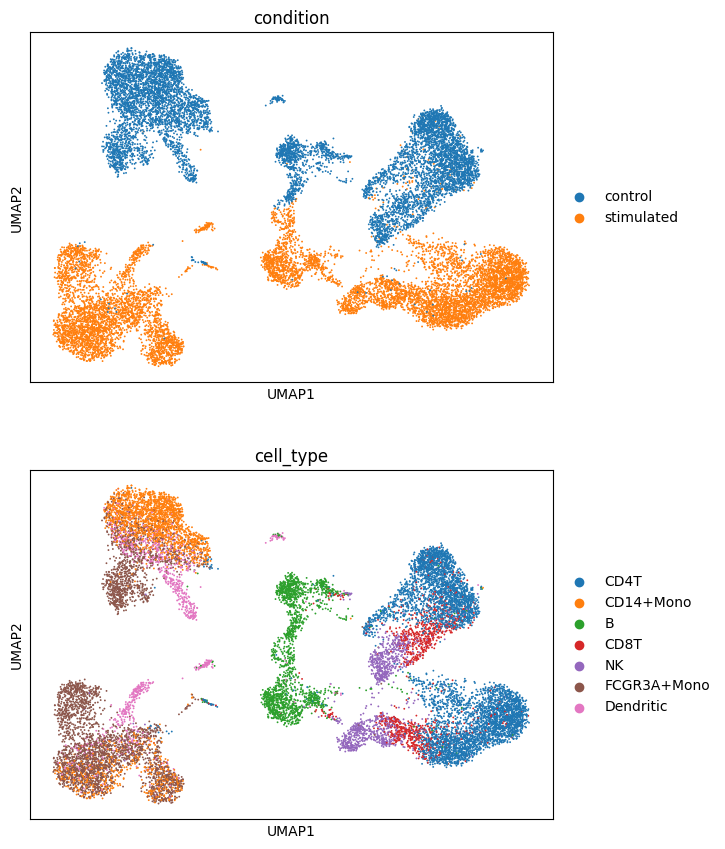

In [3]:
adata = sc.read_h5ad('../data/PBMC.h5ad')
print(adata)
print('condition',np.unique(adata.obs['condition']))
#print('batch',np.unique(adata.obs['batch']))
print('cell_type',np.unique(adata.obs['cell_type']))
print(adata.X[:10,:10])
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["condition",'cell_type'],ncols=1)

# Now, if we random permute the condition label

['control' 'stimulated']


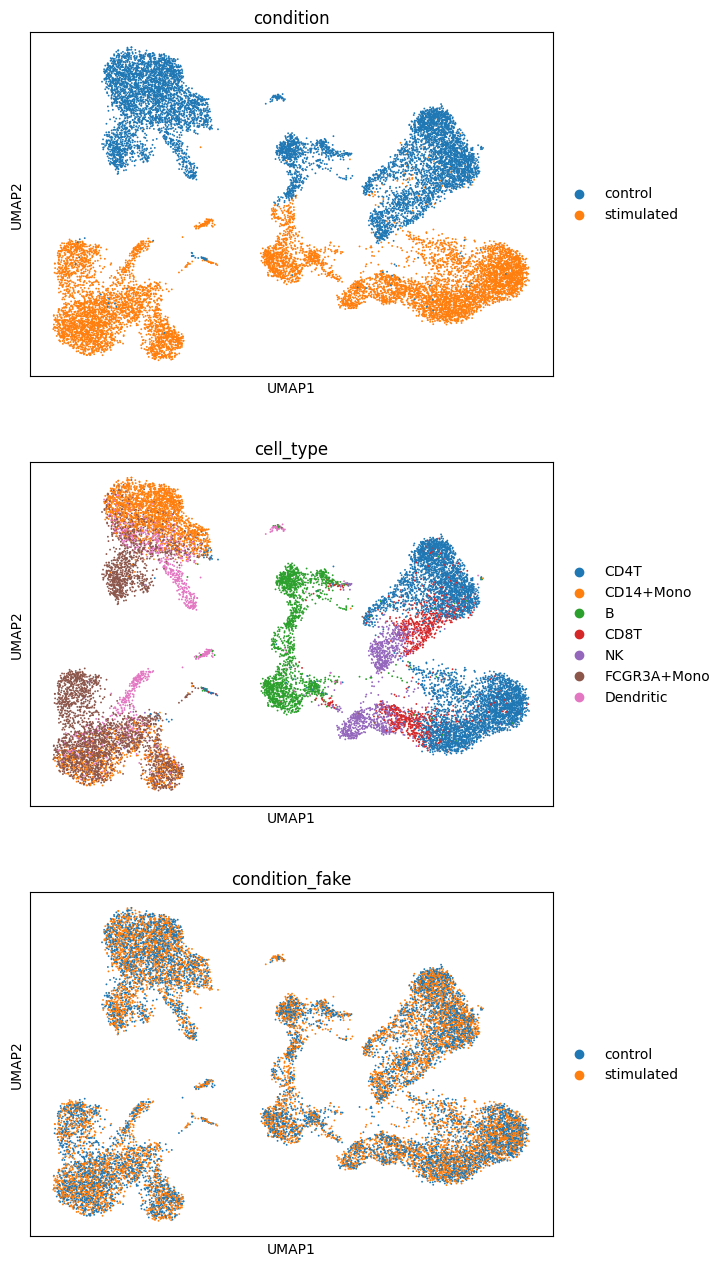

In [4]:
adata.obs["condition_fake"]=np.random.permutation(adata.obs["condition"].copy())#condition_fake
print(np.unique(adata.obs["condition_fake"]))
sc.pl.umap(adata, color=["condition",'cell_type',"condition_fake"],ncols=1)

In [5]:
model = NDreamer(adata, condition_key="condition_fake", contorl_name='control', num_hvg=2000, require_batch=False,
                        batch_key=None,
                        resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=100, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./PBMC_fake_permute/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./PBMC_fake_permute/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Start data preprocessing
Original adata.obs[condition_fake] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'control': 0, 'stimulated': 1}
Condition mapping to adata.obs['batch']: {'batch': {0: 0}}
Unique batch mapping: {0: 0}
Calculating the clusters
Unique groups: ['0_control' '0_stimulated']


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/single_cell_utils.py:38: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  clustering_function(adata, resolution=resolution1)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/single_cell_utils.py:100: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = clustered_adatas[0].concatenate(*clustered_adatas[1:], batch_key="batch_condition",


Finished clustering
Data preprocessing done
Remaining number of cells: 16893
Too few epoches (steps, if rigorously speaking). Changing epoch to 208 to adjust for number of cells
Require batch: False
Batch name to number mapping (may be used for search for saved adata):
 {'batch': {0: 0}}
Condition name to number mapping (may be used for search for saved adata):
 {'control': 0, 'stimulated': 1}
Preprocessing time: 14.79705 seconds


Overall Progress:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch: 1/208 | All Loss: 77.9077 | Neighborhood Loss: 15.8530 | Triplet Loss: 44.8556 | Reconstruction Loss: 16.6806 | Independent Loss: 10.5246 | KL Loss: 0.3565 | Commitment Loss: 0.5899 | Dependent Loss: -10.9526
Epoch: 2/208 | All Loss: 37.1974 | Neighborhood Loss: 15.3214 | Triplet Loss: 14.2221 | Reconstruction Loss: 11.1023 | Independent Loss: 7.6441 | KL Loss: 0.3796 | Commitment Loss: 0.5870 | Dependent Loss: -12.0591
Epoch: 3/208 | All Loss: 33.1365 | Neighborhood Loss: 15.0178 | Triplet Loss: 15.9988 | Reconstruction Loss: 7.8159 | Independent Loss: 5.7982 | KL Loss: 0.4330 | Commitment Loss: 0.5827 | Dependent Loss: -12.5098


KeyboardInterrupt: 

In [ ]:
adata1=model.DL_model.adata.copy()

sc.pp.neighbors(adata1, use_rep='X_effect_modifier_space_PCA', n_neighbors=25)
sc.tl.umap(adata1)
sc.pl.umap(adata1, color=["condition",'cell_type',"condition_fake"], frameon=False, ncols=1)

sc.pp.neighbors(adata1, use_rep='X_effect_modifier_space', n_neighbors=25)
sc.tl.umap(adata1)
sc.pl.umap(adata1, color=["condition",'cell_type',"condition_fake"], frameon=False, ncols=1)

In [ ]:
ITE1=sc.read_h5ad("./PBMC_fake_permute/b-0--c-1__ITE.h5ad")

sc.pp.pca(ITE1)
sc.pp.neighbors(ITE1)
sc.tl.umap(ITE1)
sc.pl.umap(ITE1, color=['cell_type'], ncols=1)

# Another way to estimate is to just use the control condition, and random assign condition to each cell

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/compat/__init__.py:358: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/compat/__init__.py:358: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


(8007, 6998)


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


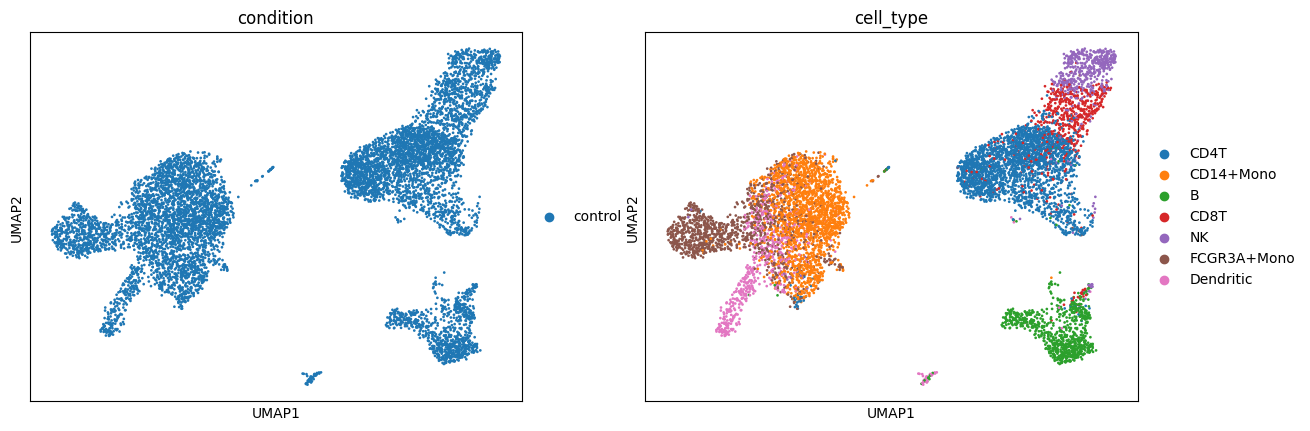

In [9]:
adata = sc.read_h5ad('../data/PBMC.h5ad')
adata2=adata[adata.obs["condition"]=="control"]
print(adata2.shape)
sc.pp.pca(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color=["condition",'cell_type'],ncols=1)

['0' '1']
['0' '1']


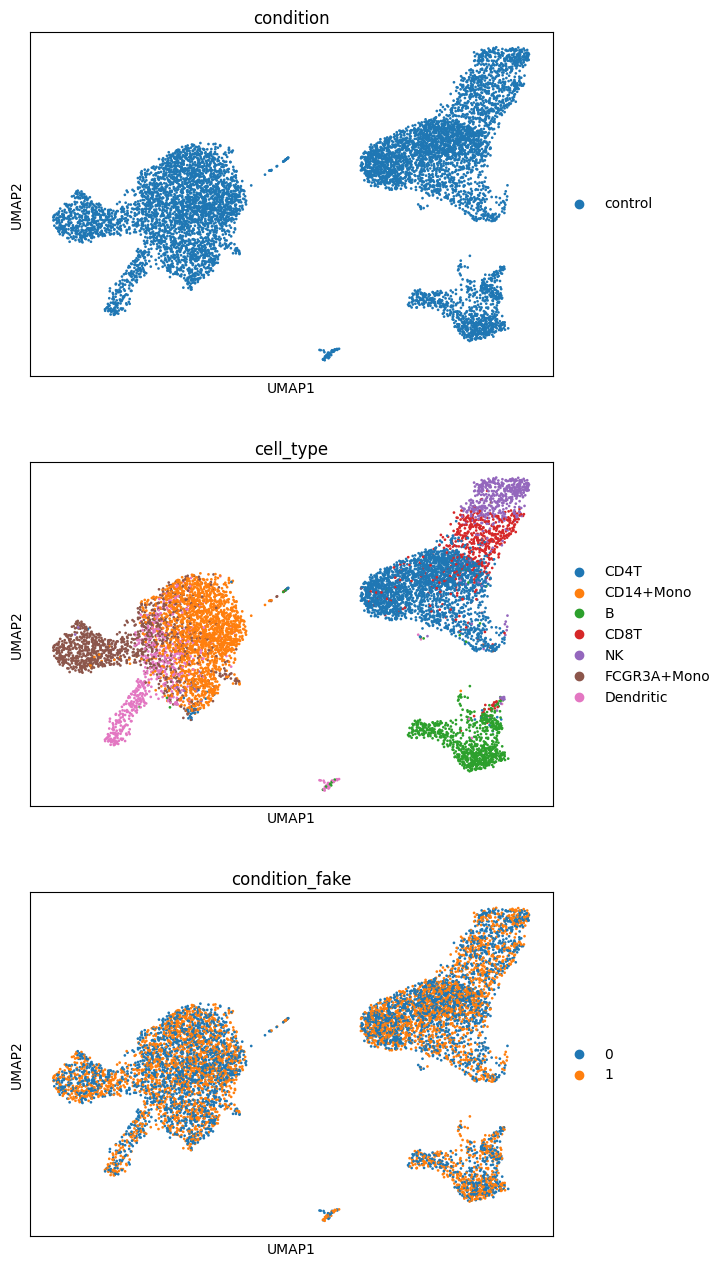

In [10]:
condition_fake=np.random.randint(0, 2, adata2.shape[0])
condition_fake=np.array([str(i) for i in condition_fake])
print(np.unique(condition_fake))
adata2.obs["condition_fake"]=condition_fake
print(np.unique(adata2.obs["condition_fake"]))
sc.pl.umap(adata2, color=["condition",'cell_type',"condition_fake"],ncols=1)

In [11]:
model = NDreamer(adata2, condition_key="condition_fake", contorl_name='0', num_hvg=2000, require_batch=False,
                        batch_key=None,
                        resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=100, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./PBMC_fake_random_part/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./PBMC_fake_random_part/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Start data preprocessing
Original adata.obs[condition_fake] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'0': 0, '1': 1}
Condition mapping to adata.obs['batch']: {'batch': {0: 0}}
Unique batch mapping: {0: 0}
Calculating the clusters
Unique groups: ['0_0' '0_1']
Finished clustering
Data preprocessing done
Remaining number of cells: 8007
Require batch: False
Batch name to number mapping (may be used for search for saved adata):
 {'batch': {0: 0}}
Condition name to number mapping (may be used for search for saved adata):
 {'0': 0, '1': 1}
Preprocessing time: 6.78413 seconds


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/single_cell_utils.py:100: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = clustered_adatas[0].concatenate(*clustered_adatas[1:], batch_key="batch_condition",


Overall Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 | All Loss: 87.6174 | Neighborhood Loss: 14.4442 | Triplet Loss: 54.6888 | Reconstruction Loss: 16.3111 | Independent Loss: 11.3131 | KL Loss: 0.3647 | Commitment Loss: 0.5890 | Dependent Loss: -10.0935
Epoch: 2/100 | All Loss: 44.5296 | Neighborhood Loss: 14.8949 | Triplet Loss: 19.8312 | Reconstruction Loss: 11.0093 | Independent Loss: 8.9911 | KL Loss: 0.3808 | Commitment Loss: 0.5855 | Dependent Loss: -11.1631
Epoch: 3/100 | All Loss: 32.5503 | Neighborhood Loss: 16.1847 | Triplet Loss: 11.4438 | Reconstruction Loss: 8.5058 | Independent Loss: 7.2794 | KL Loss: 0.4446 | Commitment Loss: 0.5905 | Dependent Loss: -11.8985


KeyboardInterrupt: 

In [ ]:
adata2=model.DL_model.adata.copy()

sc.pp.neighbors(adata2, use_rep='X_effect_modifier_space_PCA', n_neighbors=25)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color=['condition', 'cell_type'], frameon=False, ncols=1)

sc.pp.neighbors(adata2, use_rep='X_effect_modifier_space', n_neighbors=25)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color=['condition', 'cell_type'], frameon=False, ncols=1)

In [ ]:
ITE2=sc.read_h5ad("./PBMC_fake_random_part/b-0--c-1__ITE.h5ad")

sc.pp.pca(ITE2)
sc.pp.neighbors(ITE2)
sc.tl.umap(ITE2)
sc.pl.umap(ITE2, color=['cell_type'], ncols=1)